In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages


import os
import sys
# Add the parent directory to sys.path to find the utils package
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.colormaps import b_viridis, b_winter  
from utils.normalization import normalize_range, un_normalize_range
from utils.image_overlay import image_overlay


import numpy as np
import scipy.io as sio

import cv2

In [14]:
data_f = 'data'
output_f = 'results'

In [15]:
t2w_high_img = sio.loadmat(os.path.join(data_f, 't2w_high_iohexol.mat'))['t2wh']

Value t2wh in ROImask1 is  0.712 +-  0.023
Value t2wh in ROImask2 is  0.778 +-  0.027
Value t2wh in ROImask3 is  0.725 +-  0.023
Value t1w in ROImask1 is  2308.742 +-  116.537
Value t1w in ROImask2 is  2668.689 +-  118.927
Value t1w in ROImask3 is  2434.539 +-  120.839
Value t2w in ROImask1 is  463.449 +-  11.615
Value t2w in ROImask2 is  748.943 +-  33.206
Value t2w in ROImask3 is  416.249 +-  9.319
Value fs in ROImask1 is  78.840 +-  17.902
Value fs in ROImask2 is  23.234 +-  7.876
Value fs in ROImask3 is  87.616 +-  11.655
Value ksw in ROImask1 is  92.061 +-  25.960
Value ksw in ROImask2 is  294.848 +-  66.039
Value ksw in ROImask3 is  150.603 +-  28.188
Value t2wh in mask is  0.533 +-  0.083
Value t1w in mask is  1614.793 +-  213.023
Value t2w in mask is  52.509 +-  9.312
Value fs in mask is  18.991 +-  4.876
Value ksw in mask is  26.378 +-  10.503


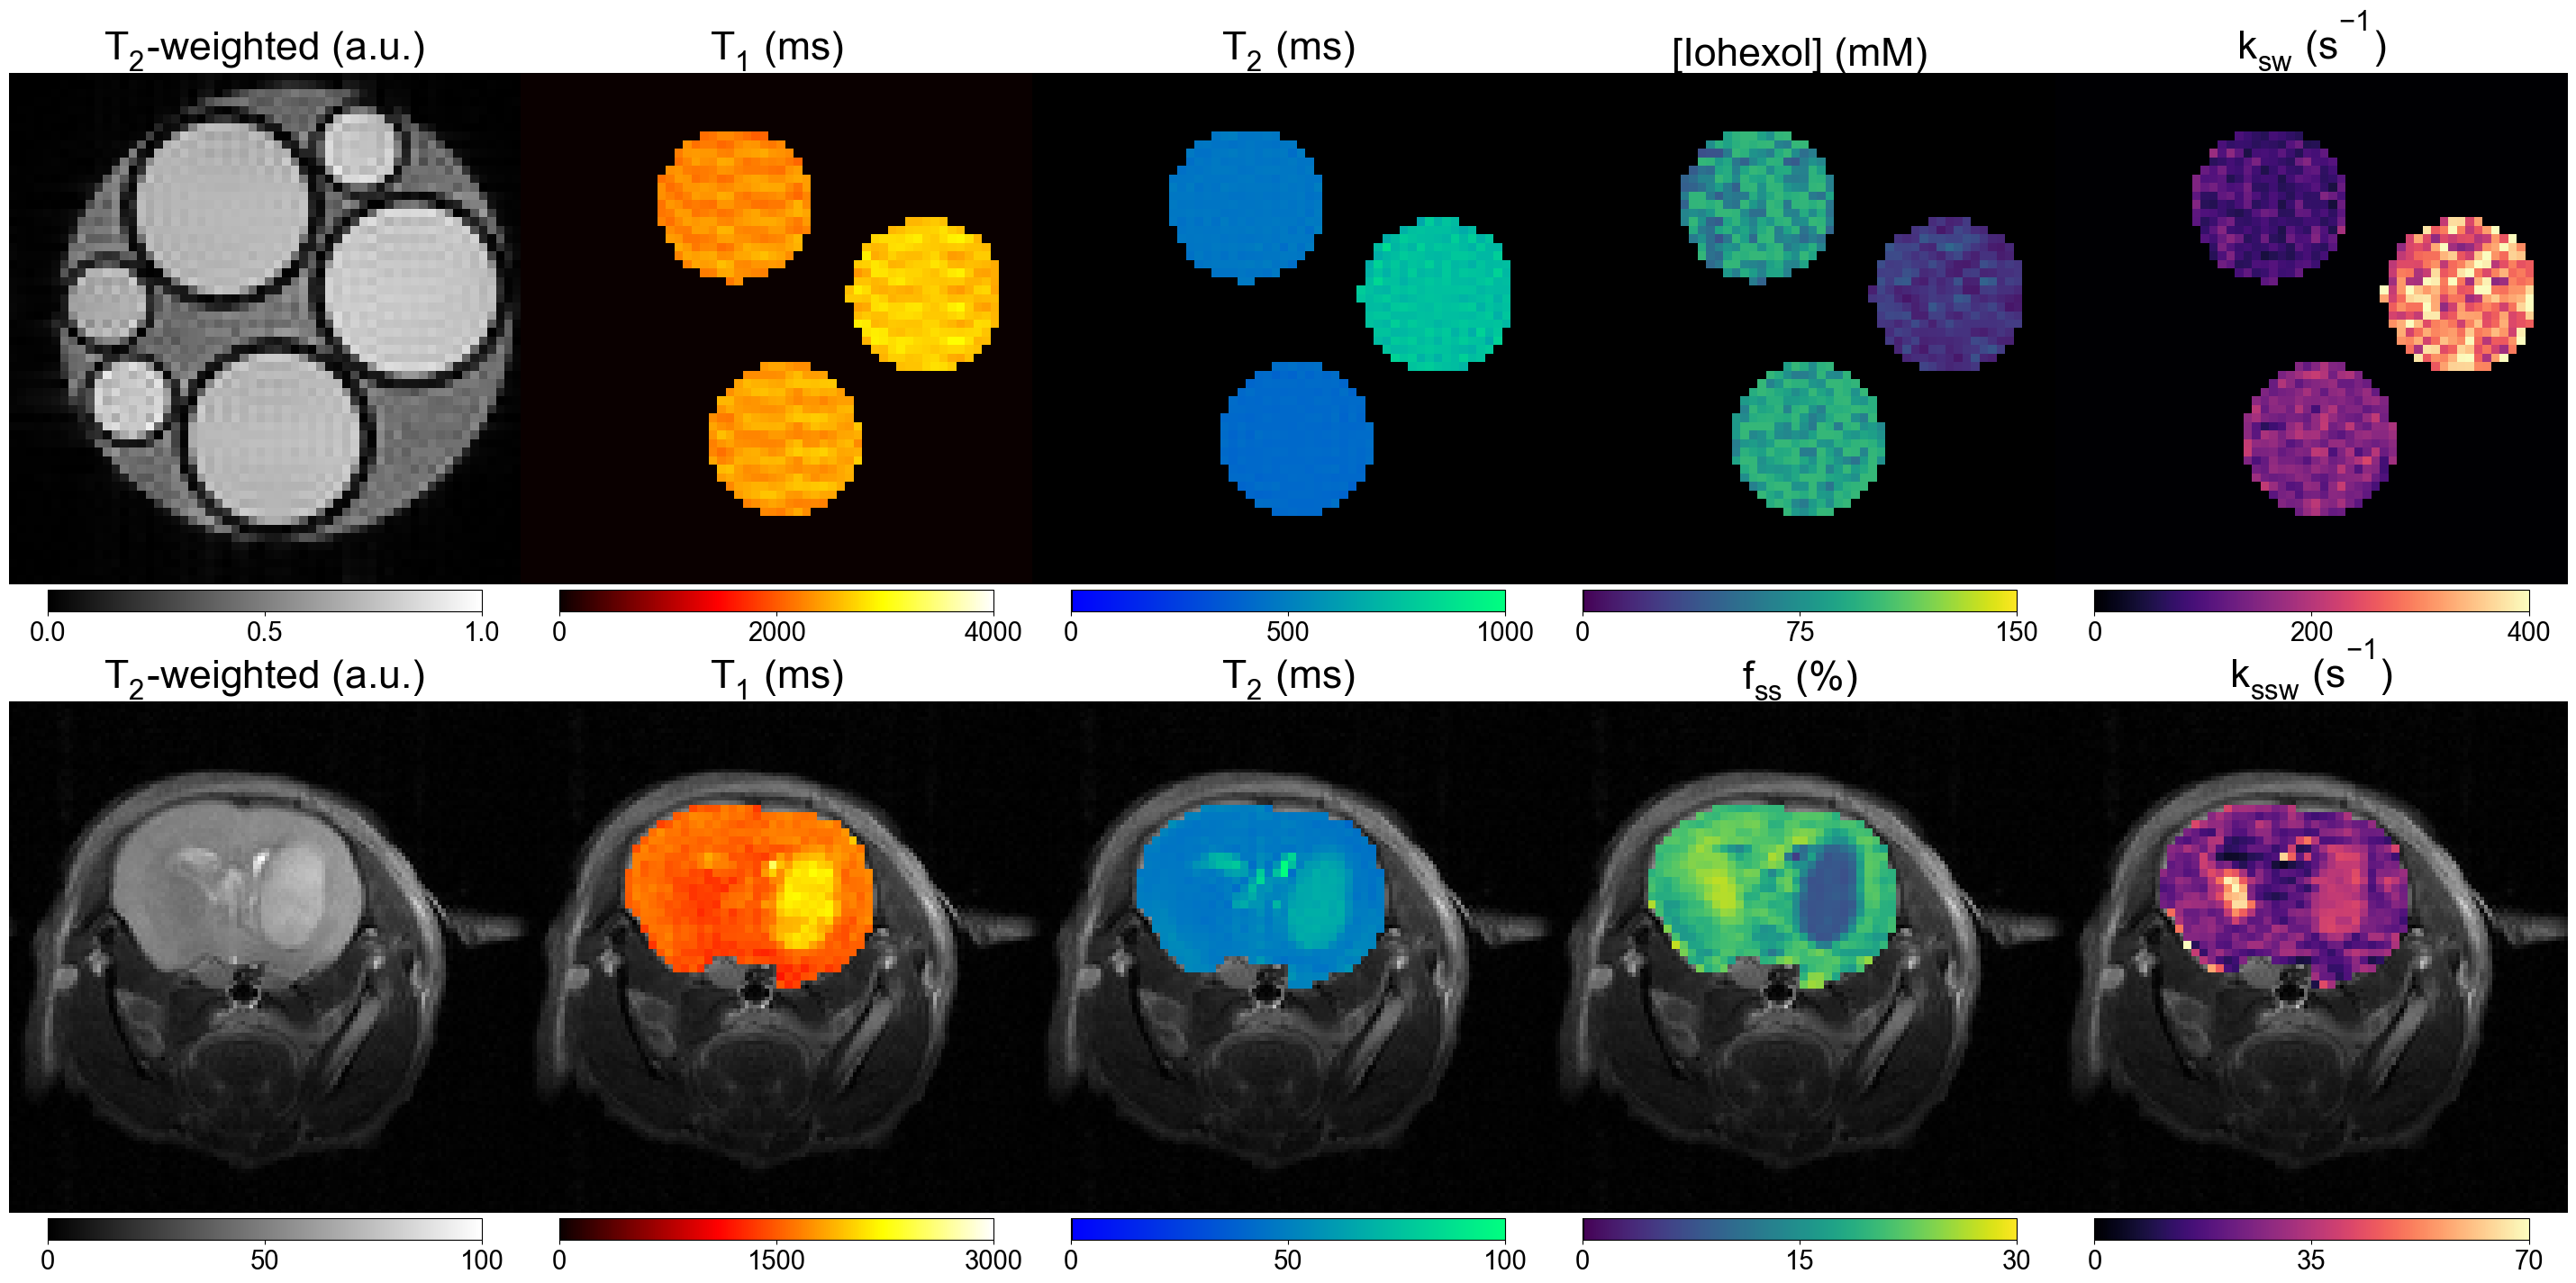

In [16]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom' 
plt.rcParams['mathtext.rm'] = 'Arial' 
plt.rcParams['mathtext.it'] = 'Arial' 
plt.rcParams['mathtext.bf'] = 'Arial:bold'

quant_maps_fn = ['nn_reco_maps.mat', 'nn_reco_maps_m.mat']
masks_fn = [ 'rois_iohexol.mat', 'mask_mouse.npy']

quant_maps_fn = [os.path.join(output_f, fn) for fn in quant_maps_fn]
masks_fn = [os.path.join(data_f, fn) for fn in masks_fn]

fig_fn = 'deep_reco' # quantitative maps output filename
fig_fn = os.path.join(output_f, fig_fn)

N_q = len(quant_maps_fn)

color_maps = ['gray','hot', b_winter, b_viridis, 'magma']*(N_q)
data_keys = ['t2wh', 't1w', 't2w', 'fs', 'ksw'] *(N_q)
titles = ['T$_{{2}}$-weighted (a.u.)','T$_{{1}}$ (ms)','T$_{{2}}$ (ms)','[Iohexol] (mM)', 'k$_{sw}$ (s$^{-1}$)']*(N_q-1)
clim_list = [(0, 1),(0, 4000), (0, 1000), (0, 150), (0, 400)]*(N_q - 1)
tick_list = [ np.arange(0, 2, 0.5),np.arange(0, 5000, 2000), np.arange(0, 1200, 500),
            np.arange(0, 180, 75), np.arange(0, 600, 200)]*(N_q - 1)

# mouse
titles = titles + ['T$_{{2}}$-weighted (a.u.)','T$_{{1}}$ (ms)','T$_{{2}}$ (ms)','f$_{{ss}}$ (%)', 'k$_{{ssw}}$ (s$^{-1}$)']
clim_list = clim_list + [(0, 100), (0, 3000), (0, 100),(0, 30), (0, 70)]
tick_list = tick_list +  [ np.arange(0, 140, 50),np.arange(0, 3300, 1500), np.arange(0, 140, 50),
            np.arange(0, 60, 15), np.arange(0, 120, 35)]

N = len(color_maps) //  N_q

unified_font_size = 32
# Save the plot to a PDF file
fig, axes = plt.subplots(N_q, 5, figsize=(29, 14))
for idx, (qm_fn, mask_fn) in enumerate(zip(quant_maps_fn, masks_fn)):
    quant_maps = sio.loadmat(qm_fn)
    if mask_fn.endswith('.npy'):
        mask = np.load(mask_fn)
    else:
        masks = sio.loadmat(mask_fn)
        mask = np.zeros_like(quant_maps['fs'], dtype=bool)
        for k, v in masks.items():
            if 'ROImask' in k:
                mask = mask | v  # Accumulate mask values
        quant_maps['t2wh'] = t2w_high_img[2]
    
    row_axes = axes[idx]  # Select the row of axes for the current file
    for ax, color_map, key, title, clim, ticks in zip(row_axes, color_maps[idx*N:(idx+1)*N], data_keys[idx*N:(idx+1)*N], titles[idx*N:(idx+1)*N], clim_list[idx*N:(idx+1)*N], tick_list[idx*N:(idx+1)*N]):
        vals = quant_maps[key]
        
        if mask_fn.endswith('.npy'):
            mask = cv2.resize(mask, (vals.shape[1], vals.shape[0]), interpolation=cv2.INTER_NEAREST)

        if key == 'fs' and not mask_fn.endswith('.npy'):
            vals = vals * 110e3/2
        elif key == 'fs' and mask_fn.endswith('.npy'):
            vals = vals * 100
        if key == 't2wh':
            vals_m = vals 
            if idx == 1:
                vals_m = np.rot90(vals_m, 3)
        else:
            vals_m = vals * mask
        plot = ax.imshow(vals_m, cmap=color_map)
        plot.set_clim(*clim)
        if idx == 0 or idx == N_q//2:
            ax.set_title(title, fontsize=unified_font_size)

        if idx == N_q - 1 or idx == N_q//2 -1:
            cb = plt.colorbar(plot, ax=ax, ticks=ticks, orientation='horizontal',fraction=0.038, pad=0.01)
            cb.ax.tick_params(labelsize=unified_font_size//1.5)
        ax.set_axis_off()

        # mouse image overlay
        if mask_fn.endswith('.npy'):
            print(f'Value {key} in mask is {np.mean(vals[mask>0]) : .3f} +- {np.std(vals[mask>0]) : .3f}')
            if key != 't2wh':
                img = image_overlay(quant_maps['t2wh'], vals, mask, plt.cm.gray, color_map, clim, None, alphabg=1, alphafg=1)
                ax.imshow(img)
            else:
                ax.imshow(vals, cmap=color_map)
        else:
            for k, v in masks.items():
                if 'ROImask' in k:
                    print(f'Value {key} in {k} is {np.mean(vals[v>0]) : .3f} +- {np.std(vals[v>0]) : .3f}')

plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.1)  # Remove spacing between subplots

plt.savefig(fig_fn+'.eps', format='eps')
plt.savefig(fig_fn+'.pdf', format='pdf')
